<a href="https://colab.research.google.com/github/Klausk0/NNFl-project/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
filename = 'drilling_dataset.csv'
df = pd.read_csv('drilling_dataset.csv')

Data Summary:
             Depth           WOB    SURF_RPM     ROP_AVG        PHIF  \
count   151.000000    151.000000  151.000000  151.000000  151.000000   
mean   3697.417219  45393.934391    2.034981    0.007800    0.084423   
std     227.169433  15784.246882    0.208492    0.001476    0.068230   
min    3305.000000  16961.916000    1.314720    0.002666    0.002968   
25%    3502.500000  34320.946500    1.998711    0.007368    0.037550   
50%    3700.000000  44243.480000    1.999697    0.008157    0.059274   
75%    3887.500000  53212.685000    2.001069    0.008760    0.097212   
max    4085.000000  97087.882000    2.639233    0.010447    0.279346   

              VSH          SW       KLOGH  
count  151.000000  151.000000  151.000000  
mean     0.299809    0.975579   37.072228  
std      0.264596    0.108946  127.186210  
min      0.049451    0.351393   -0.001124  
25%      0.108539    1.000000    0.001000  
50%      0.193100    1.000000    0.001000  
75%      0.387664    1.000000

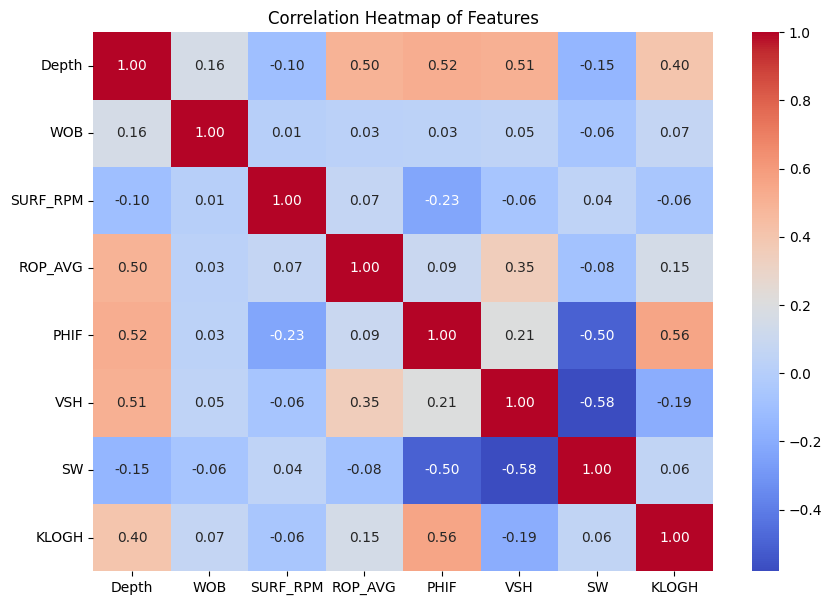

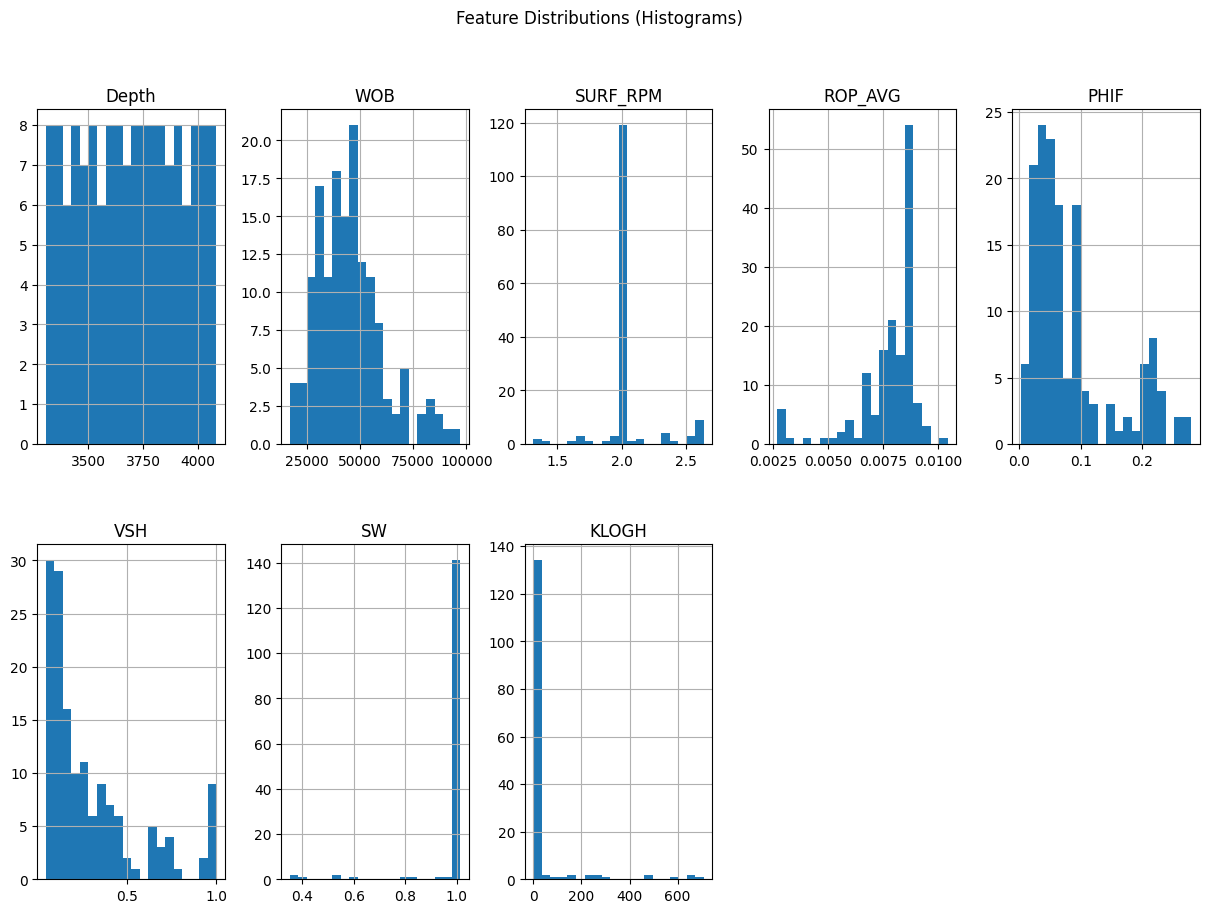

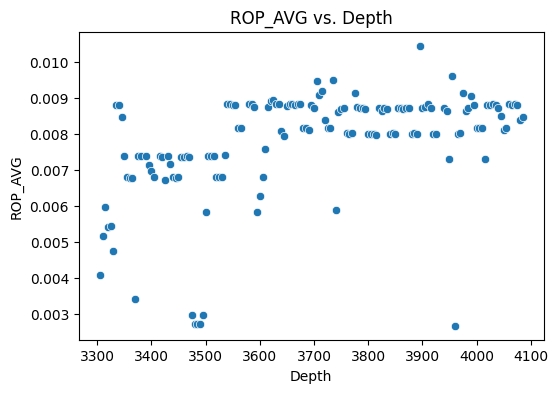

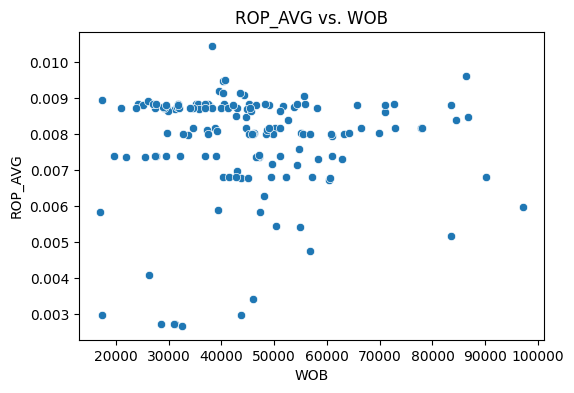

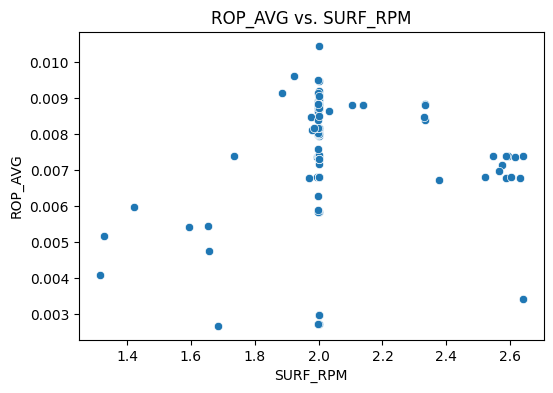

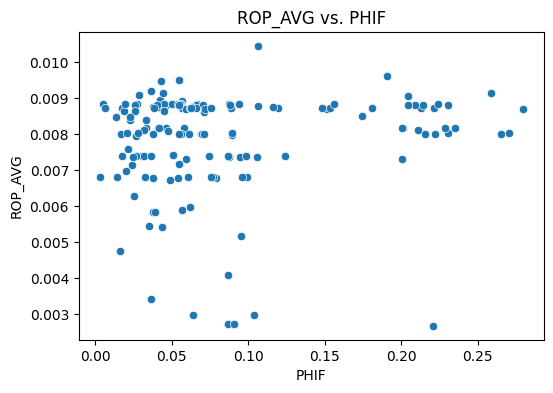

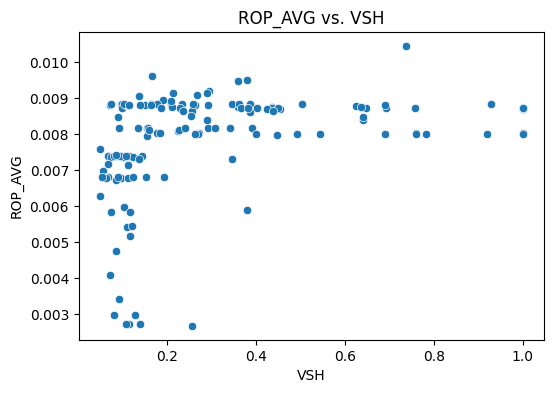

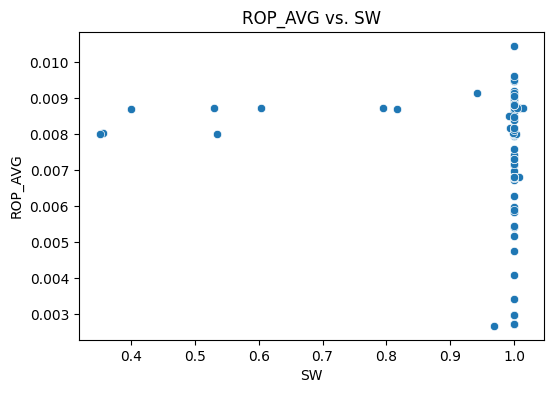

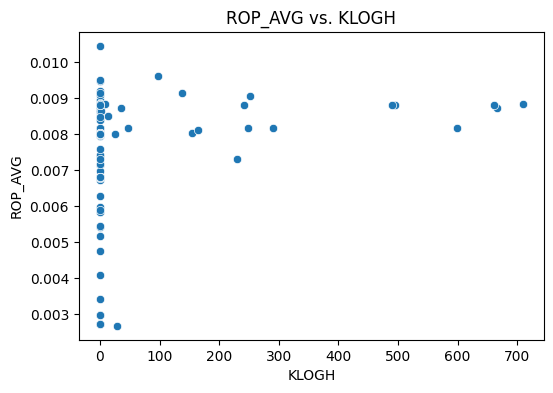

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Data Summary:")
print(df.describe())

print("\nColumn Info:")
print(df.info())

# 1. Correlation heatmap: Shows relationships among all numerical variables.
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# 2. Histograms for each key feature: Shows data spread and outliers.
key_columns = df.select_dtypes(include=[np.number]).columns
df[key_columns].hist(bins=20, figsize=(15, 10), layout=(2, int(len(key_columns)/2)+1))
plt.suptitle("Feature Distributions (Histograms)")
plt.show()

# 3. Scatterplots for ROP_AVG vs. other key features (shows how target relates to inputs).
target = "ROP_AVG"
for col in key_columns:
    if col != target:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[col], y=df[target])
        plt.xlabel(col)
        plt.ylabel(target)
        plt.title(f"{target} vs. {col}")
        plt.show()


In [8]:
# --------- 2. DATA CLEANING AND FEATURE ENGINEERING ---------

df = df.replace([np.inf, -np.inf], np.nan)
features = ["Depth", "WOB", "SURF_RPM", "PHIF", "VSH", "SW", "KLOGH"]
target = "ROP_AVG"
df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

In [9]:
# --------- 3. TRAIN/VALIDATION/TEST SPLIT ---------

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=0)


In [10]:
# --------- 4. PREPROCESSING PIPELINE ---------

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocess = Pipeline([
    ('scaler', StandardScaler())
])

X_train_prep = preprocess.fit_transform(X_train)
X_val_prep = preprocess.transform(X_val)
X_test_prep = preprocess.transform(X_test)

In [11]:
# --------- 5. MODEL TRAINING ---------

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np  # Ensure numpy is imported for sqrt

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=0, verbosity=0),
    "SVR": SVR(),
    "DecisionTree": DecisionTreeRegressor(random_state=0)
}

for name, model in models.items():
    model.fit(X_train_prep, y_train)
    val_pred = model.predict(X_val_prep)
    test_pred = model.predict(X_test_prep)
    # RMSE calculation using np.sqrt, no 'squared' argument
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    test_r2 = r2_score(y_test, test_pred)
    print(f"{name} - Validation RMSE: {val_rmse:.2f}, Test R2: {test_r2:.2f}")


RandomForest - Validation RMSE: 0.00, Test R2: 0.61
XGBoost - Validation RMSE: 0.00, Test R2: 0.53
SVR - Validation RMSE: 0.00, Test R2: -2.33
DecisionTree - Validation RMSE: 0.00, Test R2: 0.38


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_prep.shape[1],)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1)
])
nn.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
nn.fit(X_train_prep, y_train, epochs=20, batch_size=32,
       validation_data=(X_val_prep, y_val), callbacks=[early_stop], verbose=1)

nn_pred = nn.predict(X_test_prep).flatten()
# FIX: Remove 'squared=False' and use np.sqrt for RMSE
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
nn_r2 = r2_score(y_test, nn_pred)
print(f"NN - Test RMSE: {nn_rmse:.2f}, R2: {nn_r2:.2f}")


C:\Users\Ashish\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0587 - val_loss: 0.0187
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0266 - val_loss: 0.0273
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0359 - val_loss: 0.0217
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0320 - val_loss: 0.0121
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0238 - val_loss: 0.0048
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0146 - val_loss: 0.0064
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0127 - val_loss: 0.0085
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0194 - val_loss: 0.0059
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0251 - val_loss: 0.0044
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0207 - val_loss: 0.0038
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0198 - val_loss: 0.0019
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0113 - val_loss: 0.0017


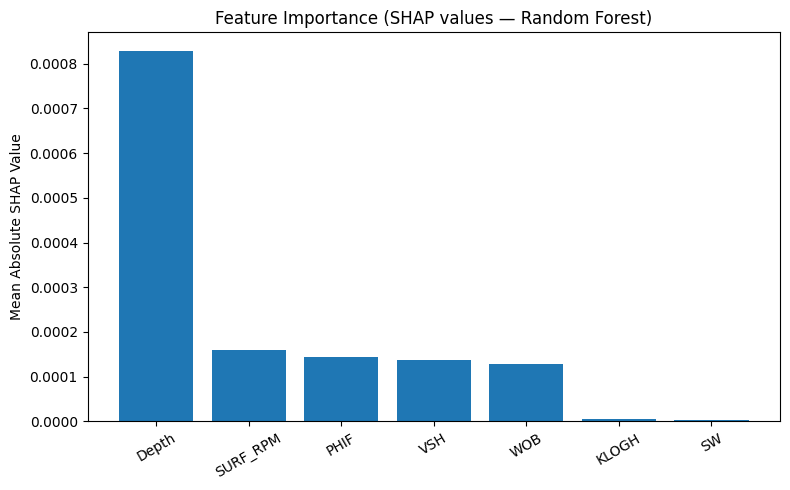

In [14]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# ---------------------------
# ✅ 1. Load Your Data
# ---------------------------
# Make sure df and features exist. If not:
# df = pd.read_csv("your_data.csv")
# features = df.columns[:-1]
# target = df.columns[-1]

X = df[features].values
y = df[target].values

# ---------------------------
# ✅ 2. Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# ✅ 3. Scale Data
# ---------------------------
scaler = StandardScaler()
X_train_prep = scaler.fit_transform(X_train)
X_test_prep = scaler.transform(X_test)

# ---------------------------
# ✅ 4. Train RandomForest
# ---------------------------
rf_model_for_shap = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf_model_for_shap.fit(X_train_prep, y_train)

# ---------------------------
# ✅ 5. Compute SHAP Values
# ---------------------------
explainer = shap.TreeExplainer(rf_model_for_shap)
shap_values = explainer.shap_values(X_test_prep)

# ---------------------------
# ✅ 6. Compute Mean SHAP Importance
# ---------------------------
feature_importance = np.abs(shap_values).mean(axis=0)
feature_names = features

# ---------------------------
# ✅ 7. Plot SHAP Bar Chart
# ---------------------------
plt.figure(figsize=(8, 5))
sorted_idx = np.argsort(feature_importance)[::-1]

plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)),
           [feature_names[i] for i in sorted_idx],
           rotation=30)
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Feature Importance (SHAP values — Random Forest)")
plt.tight_layout()
plt.show()


In [15]:

# --------- 9. SAVE MODELS & RESULTS ---------

import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(models["RandomForest"], f)

pd.DataFrame({'Actual': y_test, 'RF_Pred': models["RandomForest"].predict(X_test_prep),
              'NN_Pred': nn_pred}).to_csv('results_comparison.csv', index=False)

Sample of Real vs Predicted ROP_AVG (test wells):
   Actual ROP_AVG  Predicted ROP_AVG
0        0.009479           0.008588
1        0.006976           0.007019
2        0.009490           0.008414
3        0.008153           0.008247
4        0.008101           0.008324
5        0.007362           0.006362
6        0.009190           0.008664
7        0.007945           0.008611
8        0.006278           0.007024
9        0.008700           0.008698


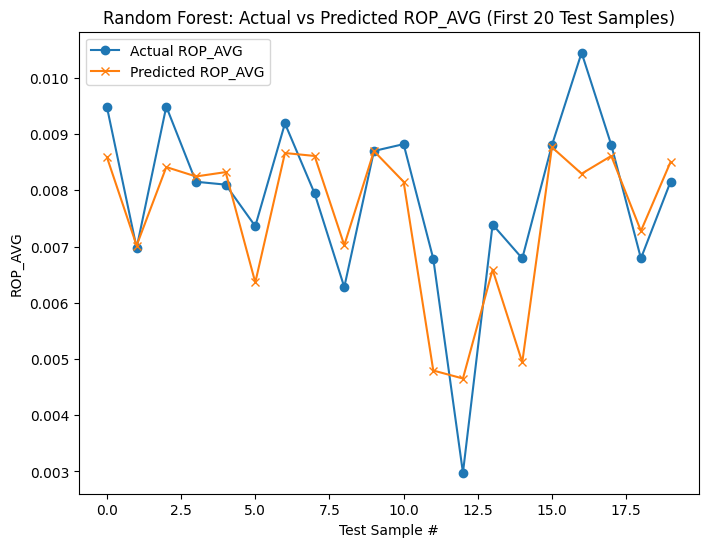

Model RMSE: 0.00
Dummy Mean Predictor RMSE: 0.00

Our ML model reduces prediction error by 34.1% compared to a naïve mean predictor!


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Choose model (e.g., Random Forest)
best_model = models["RandomForest"]

# ✅ Predict using the preprocessed test data
test_pred = best_model.predict(X_test_prep)

# ✅ y_test is already a NumPy array → use directly
results = pd.DataFrame({
    "Actual ROP_AVG": y_test,
    "Predicted ROP_AVG": test_pred
})

print("Sample of Real vs Predicted ROP_AVG (test wells):")
print(results.head(10))

# ✅ Plot first 20 samples
plt.figure(figsize=(8, 6))
plt.plot(results["Actual ROP_AVG"].values[:20], label="Actual ROP_AVG", marker='o')
plt.plot(results["Predicted ROP_AVG"].values[:20], label="Predicted ROP_AVG", marker='x')
plt.title("Random Forest: Actual vs Predicted ROP_AVG (First 20 Test Samples)")
plt.ylabel("ROP_AVG")
plt.xlabel("Test Sample #")
plt.legend()
plt.show()

# ✅ Dummy baseline (mean predictor)
mean_rop = y_test.mean()
dummy_pred = np.full_like(y_test, mean_rop)

# ✅ RMSE calculation
model_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
dummy_rmse = np.sqrt(mean_squared_error(y_test, dummy_pred))

print(f"Model RMSE: {model_rmse:.2f}")
print(f"Dummy Mean Predictor RMSE: {dummy_rmse:.2f}")

improvement = (1 - model_rmse / dummy_rmse) * 100
print(f"\nOur ML model reduces prediction error by {improvement:.1f}% compared to a naïve mean predictor!")
